In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nnfl-nlp-lab-2/lab2_test.csv
/kaggle/input/nnfl-nlp-lab-2/lab2_train.csv
/kaggle/input/nnfl-nlp-lab-2/lab2_sample.csv


In [2]:
df = pd.read_csv('../input/nnfl-nlp-lab-2/lab2_train.csv')

In [3]:
max_length = max([len(s.split()) for s in (df['text'])])

In [4]:
"""
import re
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
tokenizer = Tokenizer(num_words=10000, split = ' ')
tokenizer.fit_on_texts(df['text'].values)

max_length = max([len(s.split()) for s in (df['text'])])
                  
vocab_size = len(tokenizer.word_index) + 1

X = tokenizer.texts_to_sequences(df['text'])
X = pad_sequences(X)
X
"""

"\nimport re\ndf['text'] = df['text'].apply(lambda x: x.lower())\ndf['text'] = df['text'].apply((lambda x: re.sub('[^a-zA-z0-9\\s]','',x)))\nfrom keras.preprocessing.text import Tokenizer\nfrom keras.preprocessing.sequence import pad_sequences\ntokenizer = Tokenizer(num_words=10000, split = ' ')\ntokenizer.fit_on_texts(df['text'].values)\n\nmax_length = max([len(s.split()) for s in (df['text'])])\n                  \nvocab_size = len(tokenizer.word_index) + 1\n\nX = tokenizer.texts_to_sequences(df['text'])\nX = pad_sequences(X)\nX\n"

In [5]:
EMBEDDING_DIM=200

In [6]:
import string 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

txt = list()
lines = df['text'].values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    tokens = [w.lower() for w in tokens]
    table = str.maketrans('','',string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()]
    txt.append(words)
txt

[['awwww',
  'i',
  'fell',
  'asleep',
  'on',
  'the',
  'game',
  'but',
  'i',
  'hear',
  'the',
  'cavs',
  'win',
  'darn'],
 ['pizza',
  'amp',
  'chippies',
  'in',
  'oven',
  'malibu',
  'amp',
  'juice',
  'in',
  'hand',
  'winchester',
  'bros',
  'abt',
  'b',
  'on',
  'my',
  'computah',
  'screen',
  'can',
  'you',
  'can',
  'win',
  'boys',
  'amp',
  'girls'],
 ['bought',
  'to',
  'much',
  'stuff',
  'at',
  'lush',
  'smell',
  'like',
  'some',
  'fruitchocolateherbsmixed',
  'candy',
  'bar'],
 ['sending',
  'out',
  'emails',
  'about',
  'mountain',
  'avenue',
  'bridal',
  'having',
  'a',
  'huge',
  'sample',
  'sale',
  'this',
  'weekend'],
 ['quite', 'doubtful', 'wisdom'],
 ['just', 'had', 'red', 'mango'],
 ['sjjkimdanielle',
  'oh',
  'i',
  'live',
  'in',
  'wildwood',
  'on',
  'the',
  'bus',
  'now',
  'got',
  'ta',
  'go',
  'to',
  'ac',
  'buy',
  'things',
  'then',
  'take',
  'another',
  'bus',
  'to',
  'absecon'],
 ['merrygoldalways',

In [7]:
import gensim
model = gensim.models.Word2Vec(sentences = txt, size=EMBEDDING_DIM, window = 5, workers = 4,min_count = 1)
words = list(model.wv.vocab)
len(words)

157822

In [8]:
filename = 'embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary = False)

import os
embeddings_index = {}
f = open(os.path.join('', 'embedding_word2vec.txt'), encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [9]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(txt)
sequences = tokenizer_obj.texts_to_sequences(txt)

word_index = tokenizer_obj.word_index

txt_pad = pad_sequences(sequences, maxlen=max_length)
sentiment=df['target'].values

In [10]:

num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [11]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.initializers import Constant

model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, embeddings_initializer=Constant(embedding_matrix),input_length = max_length,trainable = False))
model.add(SpatialDropout1D(0.2))   
model.add(LSTM(60, dropout=0.2, recurrent_dropout = 0.2,return_sequences = True))
model.add(SpatialDropout1D(0.4))   
model.add(LSTM(120, dropout=0.2, recurrent_dropout = 0.2,return_sequences = False))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 200)           31564600  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 64, 200)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64, 60)            62640     
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 64, 60)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 120)               86880     
_________________________________________________________________
dense (Dense)                (None, 1)                 121       
Total params: 31,714,241
Trainable params: 149,641
Non-trainable params: 31,564,600
______________________________________

In [12]:
VALIDATION_SPLIT = 0.2
indices = np.arange(txt_pad.shape[0])
np.random.shuffle(indices)
txt_pad = txt_pad[indices]
sentiment = sentiment[indices]
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(txt_pad, sentiment, test_size=0.2, random_state=42)
"""
num_validation_samples = int(VALIDATION_SPLIT*txt_pad.shape[0])

X_train_pad = txt_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = txt_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]
"""

'\nnum_validation_samples = int(VALIDATION_SPLIT*txt_pad.shape[0])\n\nX_train_pad = txt_pad[:-num_validation_samples]\ny_train = sentiment[:-num_validation_samples]\nX_test_pad = txt_pad[-num_validation_samples:]\ny_test = sentiment[-num_validation_samples:]\n'

In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
batch_size = 512
history = model.fit(txt_pad, sentiment, epochs = 60, batch_size=batch_size, validation_split=0.2, callbacks = [EarlyStopping(monitor='val_loss',patience = 5, min_delta = 0.001)])

Epoch 1/60
350/350 [==============================] - 61s 173ms/step - loss: 0.5358 - accuracy: 0.7280 - val_loss: 0.4758 - val_accuracy: 0.7702
Epoch 2/60
350/350 [==============================] - 61s 173ms/step - loss: 0.4867 - accuracy: 0.7641 - val_loss: 0.4592 - val_accuracy: 0.7797
Epoch 3/60
350/350 [==============================] - 60s 172ms/step - loss: 0.4728 - accuracy: 0.7734 - val_loss: 0.4512 - val_accuracy: 0.7858
Epoch 4/60
350/350 [==============================] - 61s 174ms/step - loss: 0.4655 - accuracy: 0.7775 - val_loss: 0.4462 - val_accuracy: 0.7878
Epoch 5/60
350/350 [==============================] - 61s 173ms/step - loss: 0.4583 - accuracy: 0.7822 - val_loss: 0.4407 - val_accuracy: 0.7912
Epoch 6/60
350/350 [==============================] - 108s 309ms/step - loss: 0.4536 - accuracy: 0.7847 - val_loss: 0.4366 - val_accuracy: 0.7955
Epoch 7/60
350/350 [==============================] - 61s 175ms/step - loss: 0.4512 - accuracy: 0.7858 - val_loss: 0.4331 - val_a

In [14]:
accr = model.evaluate(X_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1400/1400 [==============================] - 51s 36ms/step - loss: 0.3879 - accuracy: 0.8221
Test set
  Loss: 0.388
  Accuracy: 0.822


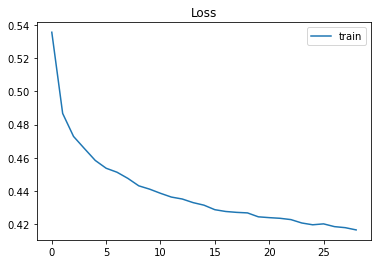

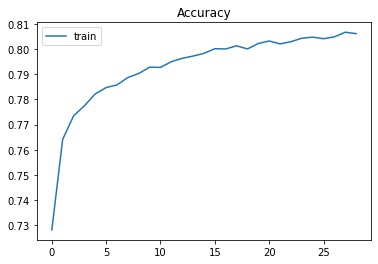

In [15]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
#plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();
 
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
#plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [16]:
model.save_weights("2018A7PS0127G.h5")

In [17]:
df_test = pd.read_csv('../input/nnfl-nlp-lab-2/lab2_test.csv')

In [18]:
"""
df_test['text'] = df_test['text'].apply(lambda x: x.lower())
df_test['text'] = df_test['text'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
new_X = tokenizer.texts_to_sequences(df_test['text'])
new_X = pad_sequences(new_X)
new_X
"""

"\ndf_test['text'] = df_test['text'].apply(lambda x: x.lower())\ndf_test['text'] = df_test['text'].apply((lambda x: re.sub('[^a-zA-z0-9\\s]','',x)))\nnew_X = tokenizer.texts_to_sequences(df_test['text'])\nnew_X = pad_sequences(new_X)\nnew_X\n"

In [19]:
# test_txt = list()
# lines = df_test['text'].values.tolist()

# for line in lines:
#     #test_tokens = word_tokenize(line)
#     #test_tokens = [w.lower() for w in test_tokens]
#     test_table = str.maketrans('','',string.punctuation)
#     test_stripped = [w.translate(test_table) for w in test_tokens]
#     words = [word for word in test_stripped if word.isalpha()]
#     test_txt.append(words)
    

In [20]:
# test_sequences = tokenizer_obj.texts_to_sequences(test_txt)
# test_txt_pad = pad_sequences(test_sequences, maxlen=max_length)


In [21]:
test_sequences = tokenizer_obj.texts_to_sequences(df_test['text'].values)
test_txt_pad = pad_sequences(test_sequences, maxlen=max_length)

In [22]:
predict = model.predict(x=test_txt_pad, verbose = 1)
predict

3000/3000 [==============================] - 112s 37ms/step


array([[0.23186311],
       [0.5493455 ],
       [0.8746065 ],
       ...,
       [0.72686416],
       [0.1835134 ],
       [0.8970496 ]], dtype=float32)

In [23]:
ans = []
for i in predict:
    if(i>0.5):
        ans.append(1)
    else:
        ans.append(0)
ans

[0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,


In [24]:
df_test = df_test['id']
df_test = pd.DataFrame(df_test)
df_test['target'] = ans
df_test

,id,target
0,48676,0
1,182034,1
2,166136,1
3,157505,1
4,212449,0
...,...,...
95995,106156,0
95996,152759,1
95997,151807,1
95998,81525,0


In [25]:
df_test.to_csv('2018A7PS0127G_Lab2_nnfl_.csv',index=False)